# ScRNA-Seq of human kidney

<br>Data from [Muto, Y. et al.](https://pubmed.ncbi.nlm.nih.gov/33850129/)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4572194

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file = '../../../../data/raw/kidney_cells/GSM4572194_Control3_filtered_feature_bc_matrix.h5'

# Read data
adata = sc.read_10x_h5(filename=file)

adata.var_names_make_unique()

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
print(adata.X.shape)
print(adata)

(6599, 33538)
AnnData object with n_obs × n_vars = 6599 × 33538
    var: 'gene_ids', 'feature_types', 'genome'


In [4]:
adata.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38-1.2.0_premrna
FAM138A,ENSG00000237613,Gene Expression,GRCh38-1.2.0_premrna
OR4F5,ENSG00000186092,Gene Expression,GRCh38-1.2.0_premrna
AL627309.1,ENSG00000238009,Gene Expression,GRCh38-1.2.0_premrna
AL627309.3,ENSG00000239945,Gene Expression,GRCh38-1.2.0_premrna


In [5]:
adata.X = adata.X.toarray()

## Preprocessing

In [6]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
AAACCTGAGGCGATAC-1    6475.0      8.775858     2551     7.844633   
AAACCTGCACGTGAGA-1     783.0      6.664409      582     6.368187   
AAACCTGGTATTCGTG-1     647.0      6.473891      538     6.289716   
AAACCTGGTGCAGACA-1    2785.0      7.932362     1538     7.338888   
AAACCTGTCCGTACAA-1   10938.0      9.300090     3919     8.273847   
...                      ...           ...      ...          ...   
TTTGTCATCCCAAGTA-1    6381.0      8.761237     2257     7.722235   
TTTGTCATCGGCTACG-1    2771.0      7.927324     1760     7.473637   
TTTGTCATCGTCACGG-1    1342.0      7.202661      968     6.876265   
TTTGTCATCGTTTATC-1    2034.0      7.618251     1314     7.181592   
TTTGTCATCTTTAGTC-1     564.0      6.336826      460     6.133398   

                    pct_counts_in_top_20_genes   mt_frac  ribo_frac  hem_frac  
AAACCTGAGGCGATAC-1                    0.185637  0.000309   0.001236       0.0  
AAACCTGCACGTGAGA-1     

In [7]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,8])

Number of cells before QC filtering: 6599
Number of cells removed by log_n_genes filtering: 0
Number of cells removed by log_n_counts filtering: 0
Number of cells removed by pct_counts_in_top_20_genes filtering: 29
Number of cells removed by mt_frac filtering: 361
Number of cells post QC filtering: 6209
Number of genes before filtering: 33538
Number of genes after filtering so theres min 20 unique cells per gene: 16575


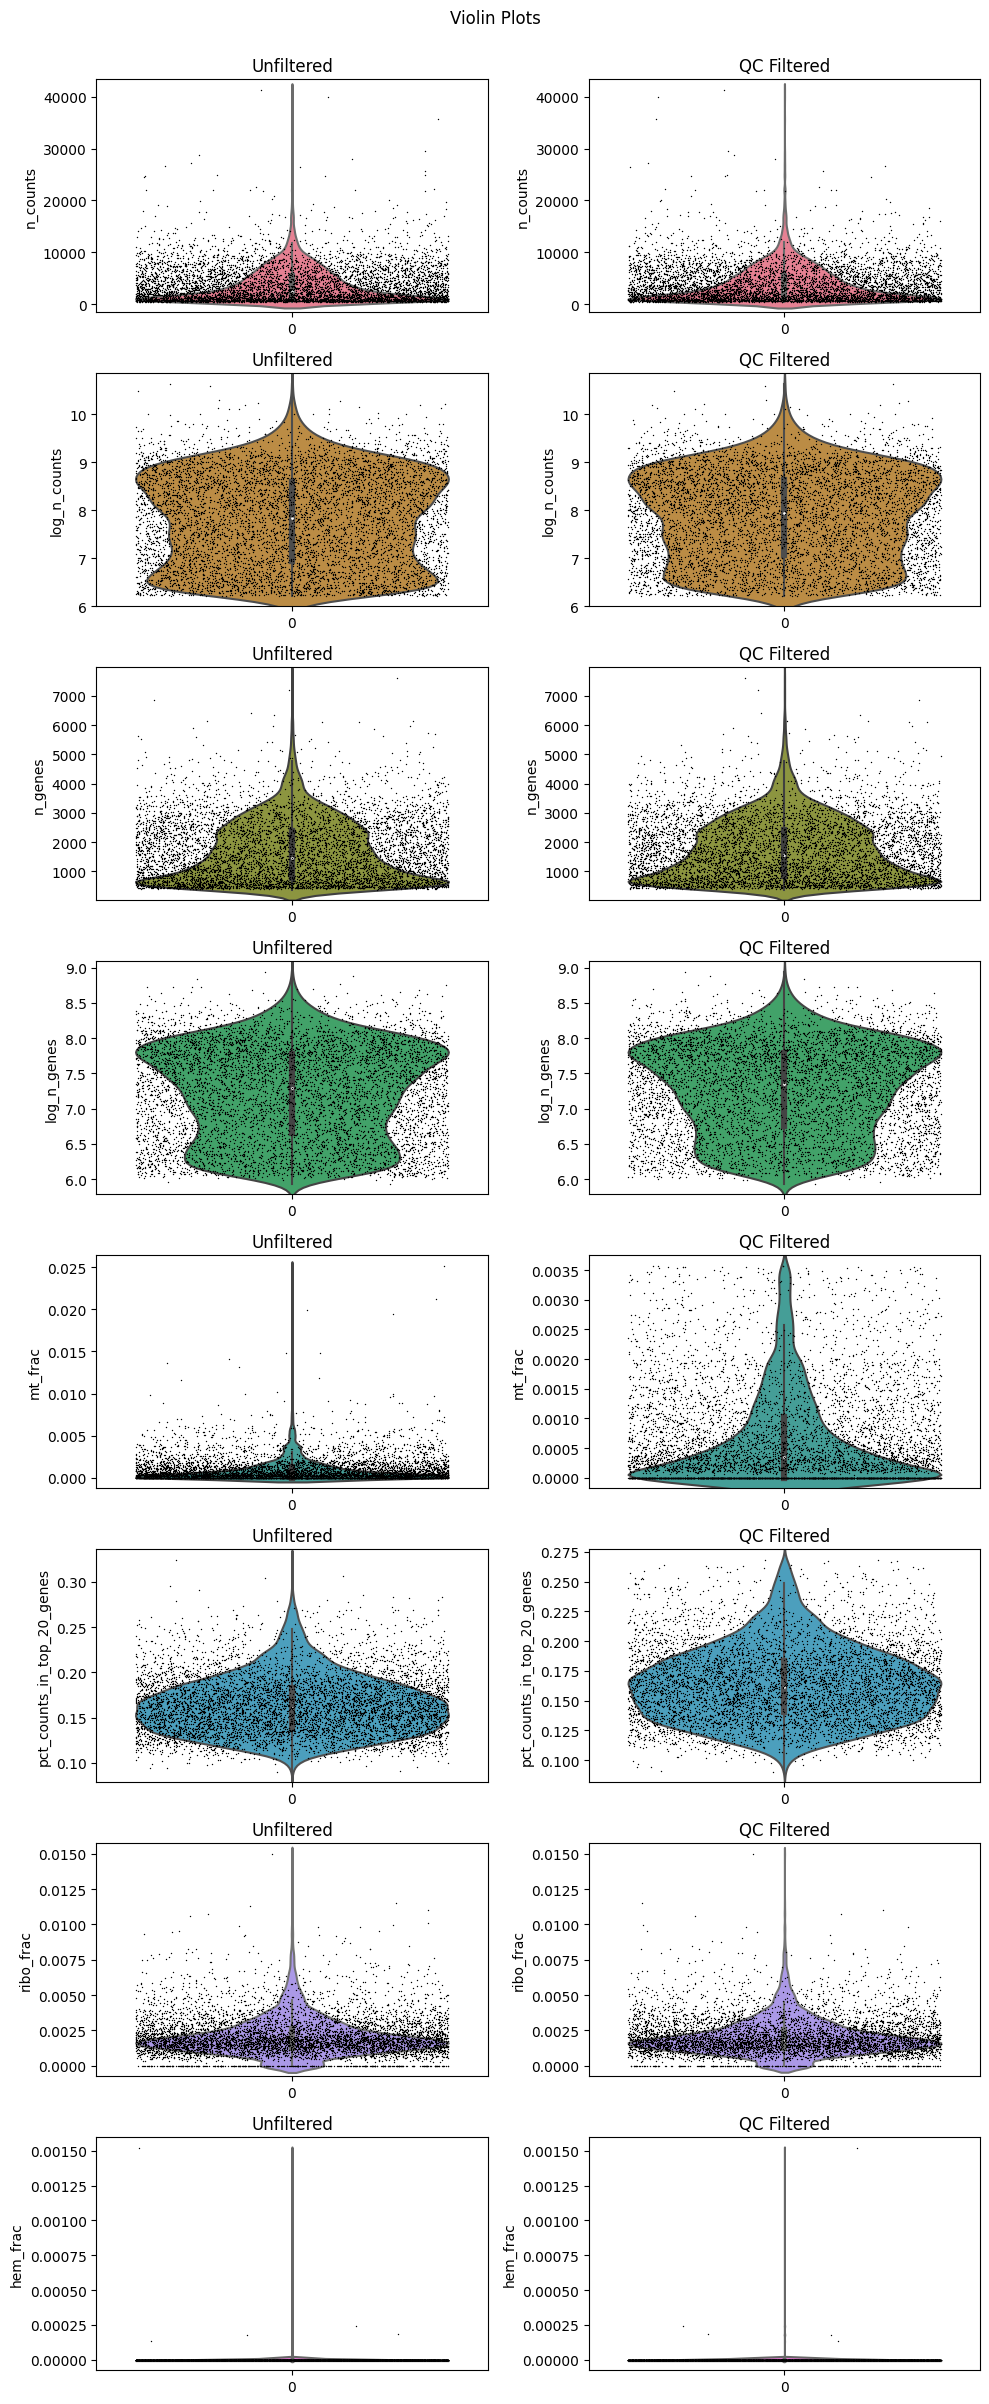

In [8]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

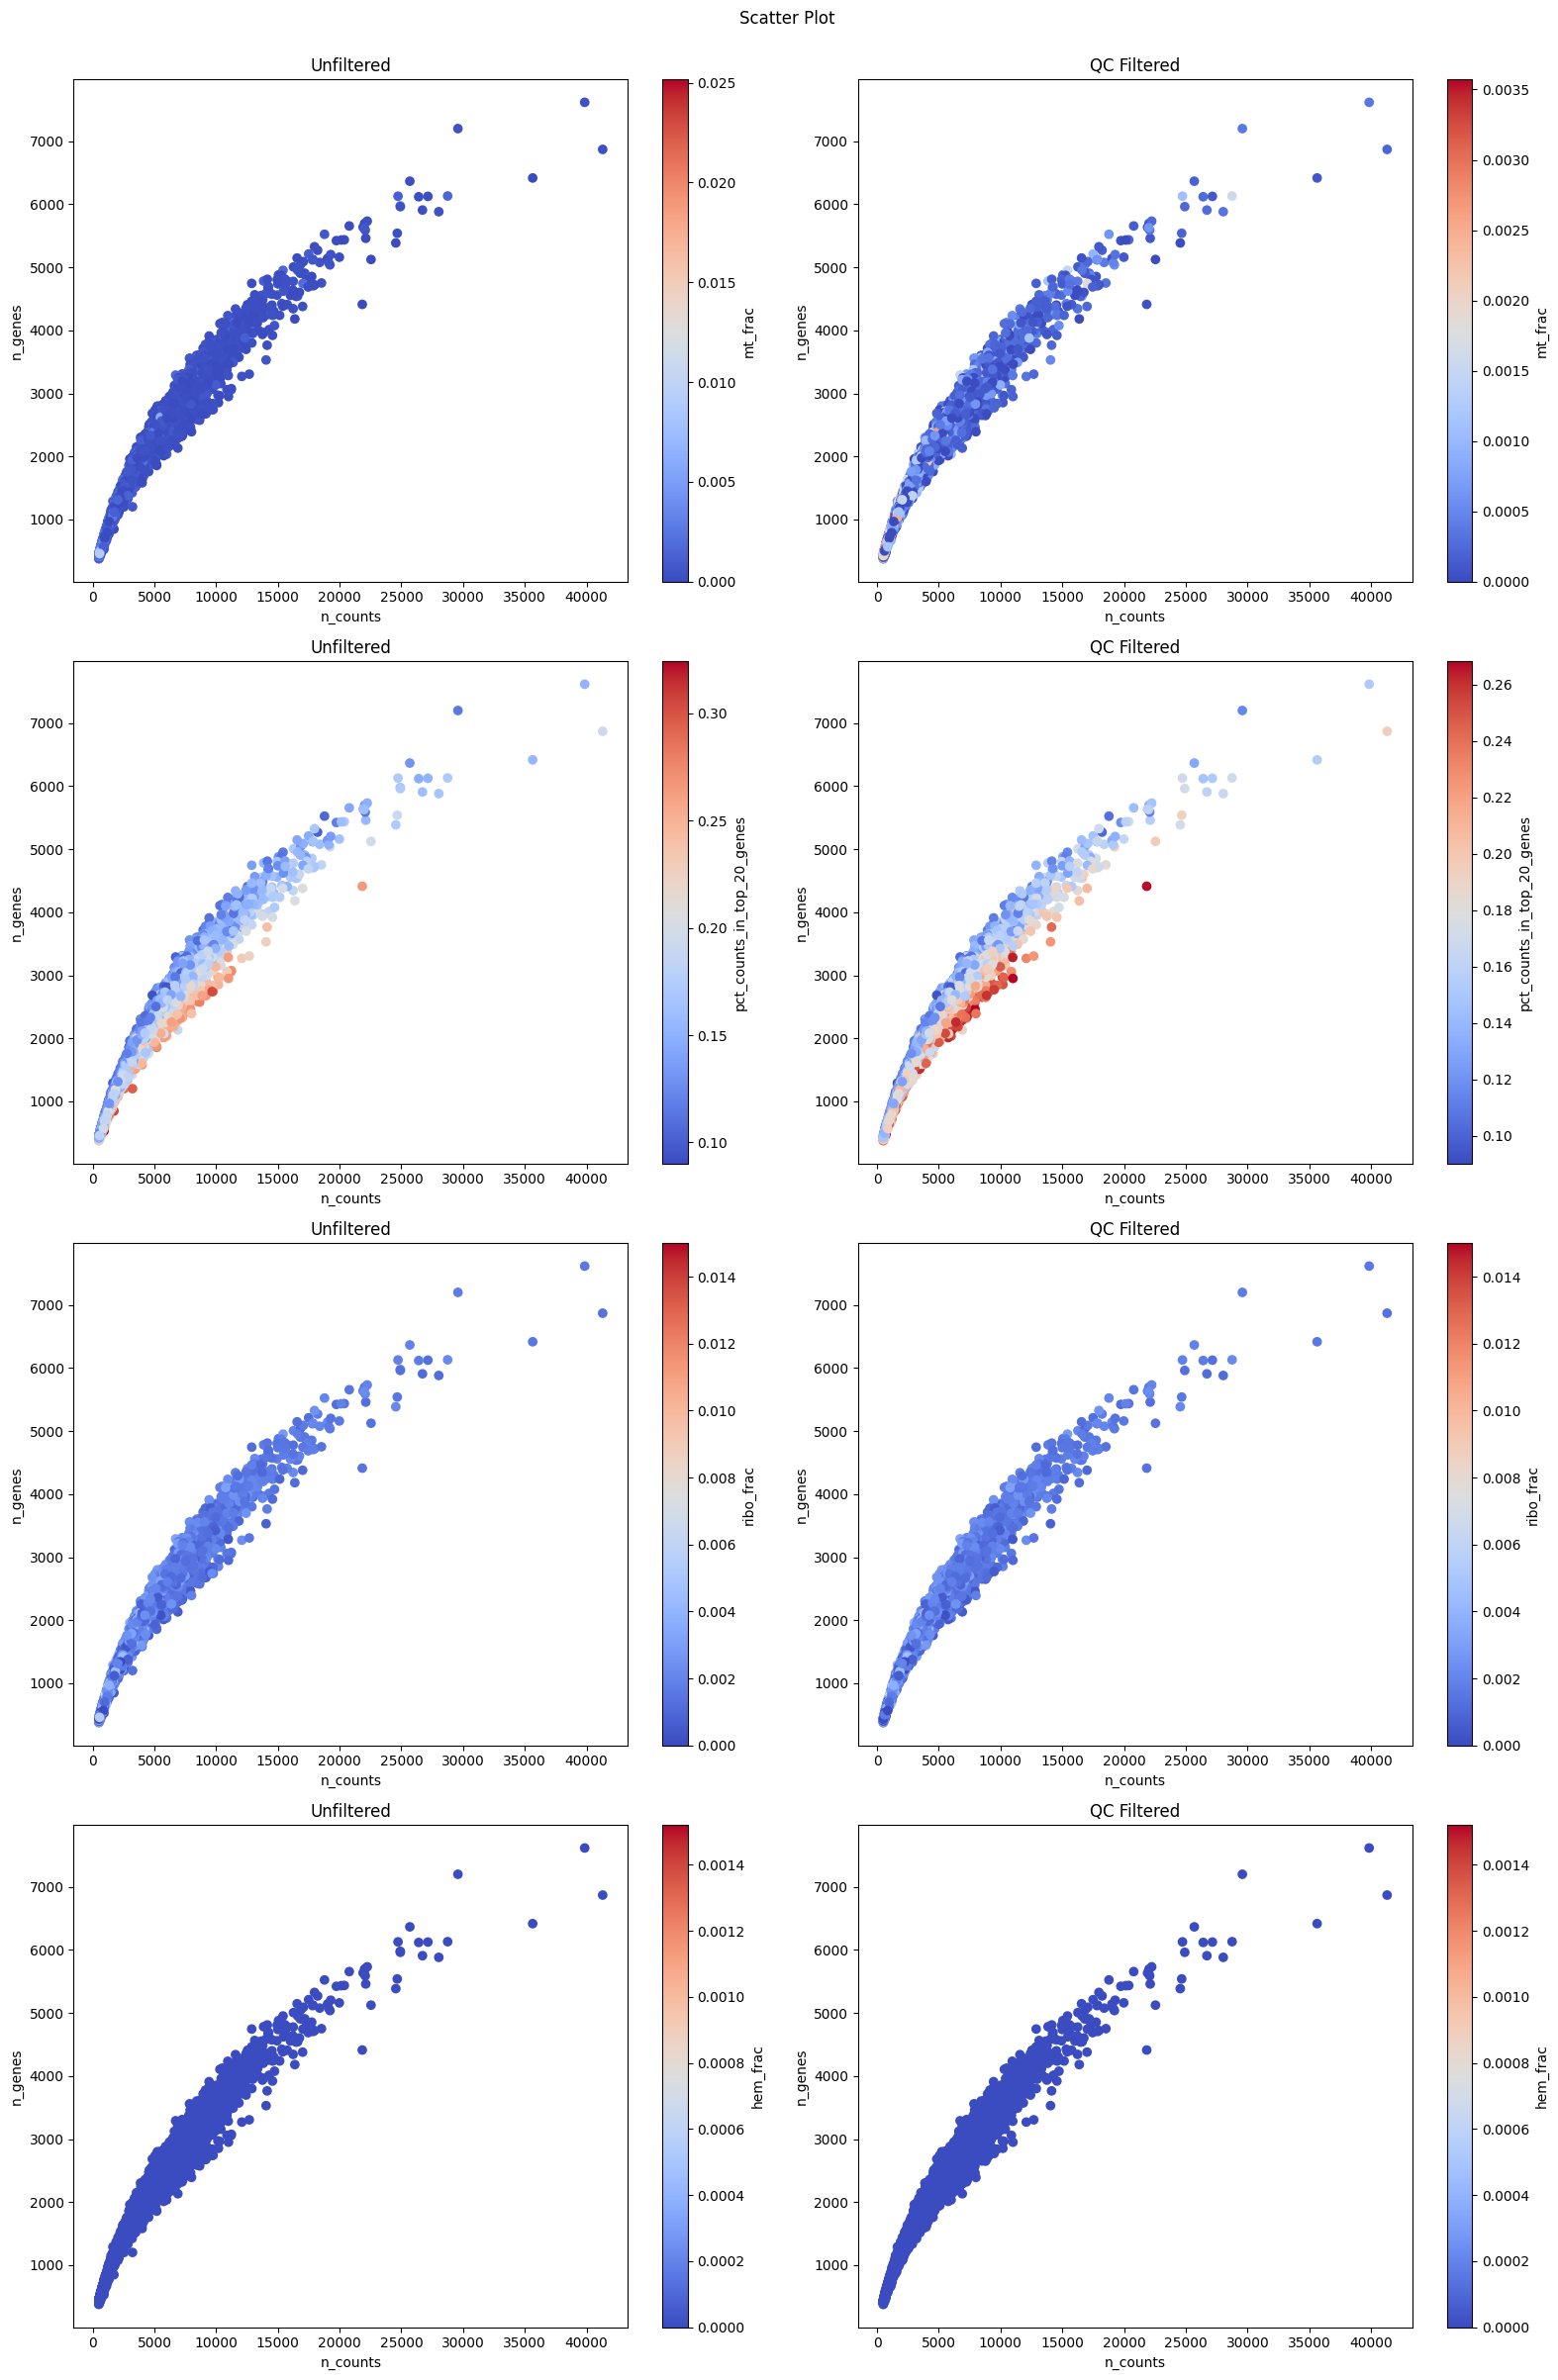

In [9]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [10]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [11]:
norm_qc_adata

AnnData object with n_obs × n_vars = 6209 × 16575
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

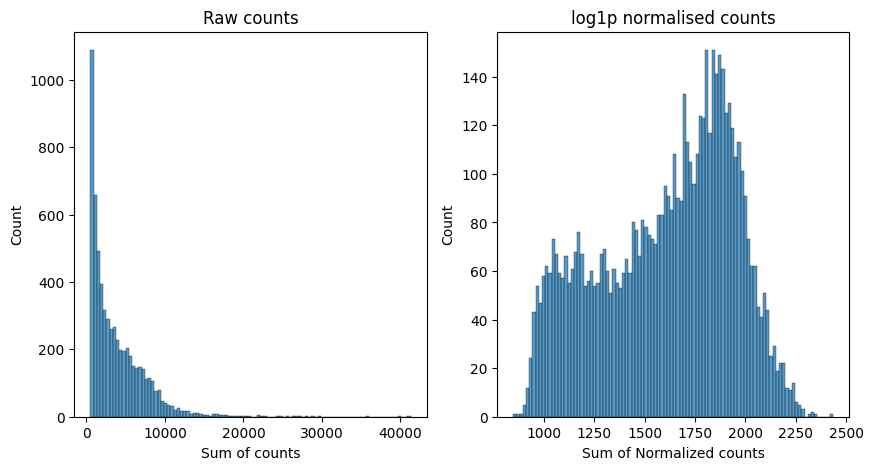

In [12]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [13]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("kidney_3.csv")
norm_qc_adata.write("kidney_3_adata.h5ad")